In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, re
import glob
import pandas as pd
%matplotlib inline
%load_ext autoreload
%autoreload 2 
from scipy import signal, fftpack
import warnings
import itertools as it
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import scale
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
import seaborn as sns
sns.set()
sns.set_context('talk')
warnings.filterwarnings('ignore')

from braintv_ephys_dev.workstation.danield import generalephys as ephys
import braintv_ephys_dev.workstation.danield.continuous_traces as traces
import braintv_ephys_dev.workstation.danield.utils as utils

In [2]:
def prep_one_probe_test_data(directory):

    spike_file = glob.glob(os.path.join(directory,'*0_0.dat'))[0]
    lfp_file = glob.glob(os.path.join(directory,'*1_0.dat'))[0]

    rms_spike_ = np.expand_dims(traces.get_probe_freq(spike_file, frequency_range=[800, 805]), 1)
    rms_lfp_ = np.expand_dims(traces.get_probe_freq(lfp_file, frequency_range=[0, 300]), 1)
    gamma_ = np.expand_dims(traces.get_probe_freq(lfp_file, frequency_range=[30, 40]), 1)
    alpha_ = np.expand_dims(traces.get_probe_freq(lfp_file, frequency_range=[8, 12]), 1)
    beta_ = np.expand_dims(traces.get_probe_freq(lfp_file, frequency_range=[12, 30]), 1)
    delta_ = np.expand_dims(traces.get_probe_freq(lfp_file, frequency_range=[0, 4]), 1)
    theta_ = np.expand_dims(traces.get_probe_freq(lfp_file, frequency_range=[4, 8]), 1)

    ## 82nd channel is always weird and can't add it to bad channels because then a different channel becomes weird, and so on
    rms_spike_[82,:] = (rms_spike_[81,:] + rms_spike_[83,:]) / 2.0
    rms_lfp_[82,:] = (rms_lfp_[81,:] + rms_lfp_[83,:]) / 2.0
    gamma_[82,:] = (gamma_[81,:] + gamma_[83,:]) / 2.0
    alpha_[82,:] = (alpha_[81,:] + alpha_[83,:]) / 2.0
    beta_[82,:] = (beta_[81,:] + beta_[83,:]) / 2.0
    delta_[82,:] = (delta_[81,:] + delta_[83,:]) / 2.0
    theta_[82,:] = (theta_[81,:] + theta_[83,:]) / 2.0

    all_bands_data = np.concatenate((rms_spike_, rms_lfp_, gamma_, alpha_, beta_, delta_, theta_), axis=1)
    
    return all_bands_data

In [3]:
def shuffle_data(features, targets):
    if features.shape[0] != targets.shape[0]:
        raise Exception('arguments not equal length')
        
    shuffle_array = np.array([[np.random.rand()] for i in range(features.shape[0])])
    shuffled_lists = sorted(zip(features, targets, shuffle_array), key=lambda x: x[2])
    features, targets, shuffled_array = [[x[i] for x in shuffled_lists] for i in range(3)]
    return np.array(features), np.array(targets)

In [4]:
def plot_hyperplane(clf, min_x, max_x, linestyle, label):
    # get the separating hyperplane
    w = clf.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(min_x - 5, max_x + 5)  # make sure the line is long enough
    yy = a * xx - (clf.intercept_[0]) / w[1]
    plt.plot(xx, yy, linestyle, label=label)


def plot_subfigure(X, Y, test_x, test_y, subplot, structure, transform, C_value):
    if transform == "pca":
        X = PCA(n_components=2).fit_transform(X)
        test_x = PCA(n_components=2).fit_transform(test_x)
    elif transform == "cca":
        X = CCA(n_components=2).fit(X, Y).transform(X)
        test_x = CCA(n_components=2).fit(test_x, Y).transform(test_x)
    else:
        raise ValueError

    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])

    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    
    test_min_x = np.min(test_x[:, 0])
    test_max_x = np.max(test_x[:, 0])
    
    test_min_y = np.min(test_x[:, 1])
    test_max_y = np.max(test_x[:, 1])
    
    classif = OneVsRestClassifier(SVC(C=C_value, 
                                      kernel='linear',
                                      degree=1, 
                                      gamma= 1.0 / 7,
                                      coef0=0.0, 
                                      shrinking=True, 
                                      probability=False, 
                                      tol=0.0001, 
                                      cache_size=200, 
                                      class_weight='balanced', 
                                      verbose=False, 
                                      max_iter=-1, 
                                      decision_function_shape='ovr', 
                                      random_state=None))
    classif.fit(X, Y)

    
    
    plt.figure(figsize=(16,8))
    plt.subplot(1, 2, 1)
    plt.title('Training Data PCA', fontsize=20)

    zero_class = np.where(Y[:, 0])
    one_class = np.where(Y[:, 1])
    plt.scatter(X[:, 0], X[:, 1], s=40, c='gray')
    plt.scatter(X[zero_class, 0], X[zero_class, 1], s=160, edgecolors='b',
               facecolors='none', linewidths=2, label='Other')
    plt.scatter(X[one_class, 0], X[one_class, 1], s=80, edgecolors='orange',
               facecolors='none', linewidths=2, label=structure)

    plot_hyperplane(classif.estimators_[0], min_x, max_x, 'k--',
                    'Boundary')
#     plot_hyperplane(classif.estimators_[1], min_x, max_x, 'k-.',
#                     'Boundary for class 2')
#     plt.xticks(())
#     plt.yticks(())

    plt.xlim(min_x - .5 * max_x, max_x + .5 * max_x)
    plt.ylim(min_y - .5 * max_y, max_y + .5 * max_y)
    if subplot == 2:
        plt.xlabel('First principal component')
        plt.ylabel('Second principal component')
        plt.legend(loc="lower right")
        
    
    ## TRAINING PCA WITH HYPERPLANE FROM TRAINING DATA

    plt.subplot(1, 2, 2)
    plt.title('Testing Data PCA', fontsize=20)

    zero_class = np.where(test_y[:, 0])
    one_class = np.where(test_y[:, 1])
    plt.scatter(test_x[:, 0], test_x[:, 1], s=40, c='gray')
    plt.scatter(test_x[zero_class, 0], test_x[zero_class, 1], s=160, edgecolors='b',
               facecolors='none', linewidths=2, label='Other')
    plt.scatter(test_x[one_class, 0], test_x[one_class, 1], s=80, edgecolors='orange',
               facecolors='none', linewidths=2, label=structure)

    plot_hyperplane(classif.estimators_[0], test_min_x, test_max_x, 'k--',
                    'Boundary')
#     plot_hyperplane(classif.estimators_[1], test_min_x, test_max_x, 'k-.',
#                     'Boundary for class 2')
#     plt.xticks(())
#     plt.yticks(())

    plt.xlim(min_x - .5 * max_x, max_x + .5 * max_x)
    plt.ylim(min_y - .5 * max_y, max_y + .5 * max_y)
    if subplot == 2:
        plt.xlabel('First principal component')
        plt.ylabel('Second principal component')
        plt.legend(loc="lower right")

## Structure to Test

In [5]:
struct = 'white matter'

## Training Data - the probe averages

In [13]:
training_data.head()

,Unnamed: 0,rms_spike,rms_lfp,gamma,alpha,beta,delta,theta,peaks,targets
0,0,0.101283,9.261163,21.871880,112.888103,50.774044,50.729492,88.434784,25.428571,nucleus accumbens
1,1,0.095130,6.771591,11.278967,96.148983,38.259240,42.515525,75.862852,26.380952,caudate putamen
2,2,0.089123,5.321826,5.639884,86.472363,31.429134,37.815071,68.721940,25.068966,white matter
3,3,0.074130,5.291393,4.128761,95.439975,28.738385,42.346282,78.121547,27.441379,primary motor cortex
4,4,0.038933,0.206789,0.198206,1.438690,0.650116,0.663794,1.150930,10.531250,above


In [7]:
training_data = pd.read_csv('chunked_banded_data.csv')
training_features = training_data.drop(['targets'],axis=1).as_matrix().astype(np.float32)
training_targets = training_data.as_matrix(columns=['targets'])
norm_training_features = scale(training_features)
print(training_features.shape)
print(training_targets.shape)

(60, 9)
(60, 1)


In [9]:
training_less_targets = np.empty((0,2))
for target in training_targets[:,0]:
    if target.lower() == struct.lower():
        training_less_targets = np.append(training_less_targets, [[0,1]], axis=0)
    else:
        training_less_targets = np.append(training_less_targets, [[1,0]], axis=0)

## Test Data from Probe Averages

In [8]:
testing_data = pd.read_csv('not_chunked_banded_data.csv')
testing_features = testing_data.drop(['targets'],axis=1).as_matrix().astype(np.float32)
testing_targets = testing_data.as_matrix(columns=['targets'])
norm_testing_features = scale(testing_features)
print(testing_features.shape)
print(testing_targets.shape)

(3366, 9)
(3366, 1)


In [10]:
testing_less_targets = np.empty((0,2))
for target in testing_targets[:,0]:
    if target.lower() == struct.lower():
        testing_less_targets = np.append(testing_less_targets, [[0,1]], axis=0)
    else:
        testing_less_targets = np.append(testing_less_targets, [[1,0]], axis=0)

## Prep Data

In [11]:
train_x, train_y = shuffle_data(norm_training_features, training_less_targets)
test_x = norm_testing_features
test_y = testing_less_targets

## Visualize PCA

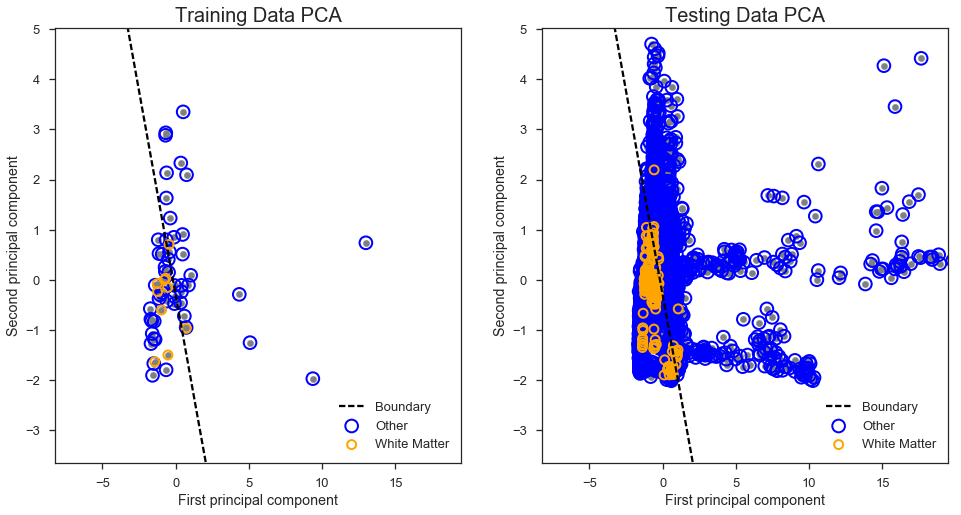

In [12]:
plot_subfigure(train_x, train_y, test_x, test_y, 2, struct.title(), 'pca', 25.0)